In [1]:
import requests, re, sys, os
import pandas as pd

from bs4 import BeautifulSoup
from datetime import datetime

from urllib.request import urlopen
import time
import matplotlib.pyplot as plt

from collections import Counter
import operator
import seaborn as sns
import socket
import pygeoip

from datetime import datetime
import matplotlib.ticker as ticker
from scipy import interpolate


In [2]:
df=pd.DataFrame(columns=['date','site','attacker','mirror','os'])

In [4]:


sess = requests.session()


#inspect code from zoneh.org to find the the cookie information
Cookie = {
    'ZHE':'080***************************e5',
    'PHPSESSID':'o4**********************a0'
    
}




In [8]:
url='http://zone-h.org/archive/special=1/page='
count=0
print("Processing pages: ")
for i in range(1,51):
    if i!=1:
        print(',', end = ' ')
    url2=url+str(i)
        
    data = sess.get(url2, cookies=Cookie)
    data2 = data.content
    bs = BeautifulSoup(data2, 'lxml')
    table_body = bs.find('table')
    rows = table_body.find_all('tr', class_=None)[1:]
    #count=0
    
    for row in rows:
            entry = row.findAll('td')

            if len(entry) > 1:
                
                date = entry[0].text
                attacker = entry[1].text
                site = entry[7].text
                os = entry[8].text
                mirror = entry[9].find('a').get('href')
               
                df.loc[count] = [date,site,attacker,mirror,os] 
                count+=1
    
    time.sleep(5)
    print(i, end='')# Be nice with the webserver

print('.\n')
          

Processing pages: 
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50.



In [10]:
df['site']=df['site'].apply(lambda x: str(x).replace('\n','').replace('\t',''))

In [19]:
df.head()

,attacker,date,mirror,os,site
0,./Xi4u7,2019/04/22,/mirror/id/32351245,Linux,sanluis.gob.mx/k.php
1,PekapuranBerjaya,2019/04/22,/mirror/id/32351133,F5 Big-IP,absensi.kemendag.go.id/bitch.html
2,Akbar dravinky,2019/04/22,/mirror/id/32351102,Linux,pkk.mubakab.go.id
3,PRdV,2019/04/22,/mirror/id/32346511,Linux,www.pped.ie.ufrj.br/media/
4,PRdV,2019/04/22,/mirror/id/32346510,Linux,www.app.ie.ufrj.br/media/


In [22]:
len(df)

1298

### Store the dataframe locally so we won't have to download it again...

In [23]:
df.to_csv('zoneh-data/zoneh-archive-v02.csv')

In [24]:
len(df)

1298

### Check the dates of the attacks

In [25]:
def date_format_func(x):
    try:
        return datetime.strptime(x, "%Y/%m/%d").date()
    except:
        return pd.NaT
    

In [26]:
dailydf=df.groupby(['date']).size().reset_index(name='count')

In [27]:
dailydf['date']=dailydf['date'].apply(date_format_func)

In [28]:
dailydf.set_index('date', inplace=True)

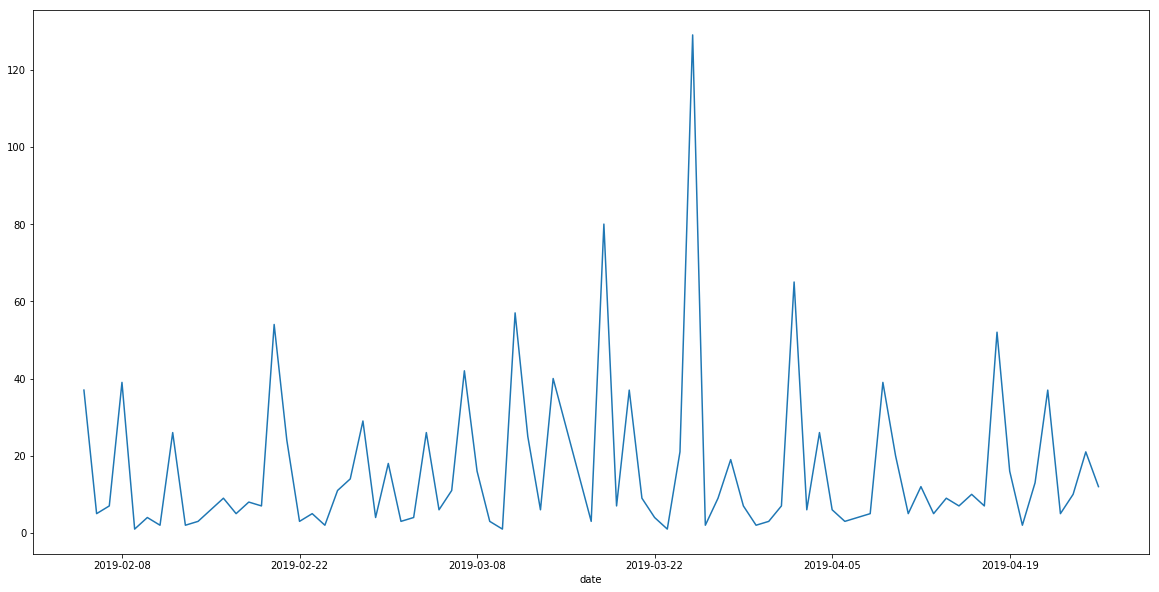

In [29]:
ax = plt.subplots(figsize=(20, 10))
ax = dailydf['count'].plot()
plt.show()

## Checking the stats of the attacked systems

In [104]:
def returnDict(df):
    
    mydict=dict(Counter(df))
    mydict=sorted(mydict.items(), key=operator.itemgetter(1))
    mydict=mydict[::-1]
    return mydict

In [105]:
mydict=returnDict(df['os'])

In [106]:
mydict

[('Linux', 994),
 ('Win 2012', 121),
 ('Unknown', 102),
 ('Win 2008', 44),
 ('FreeBSD', 13),
 ('Win 2016', 8),
 ('F5 Big-IP', 8),
 ('Win 2003', 4),
 ('OpenBSD', 3),
 ('MacOSX', 1)]

In [36]:
df.columns

Index(['attacker', 'date', 'mirror', 'os', 'site'], dtype='object')

In [45]:
labels = [str(x[0])+": "+str(x[1]) for x in mydict]
sizes = [x[1] for x in mydict]
explode= (0.2,0,0,0,0,0,0,0,0)


In [46]:
pcts=[]
for el in sizes:
    pcts.append(str(100*float(el)/sum(sizes))[0:5]+' %')

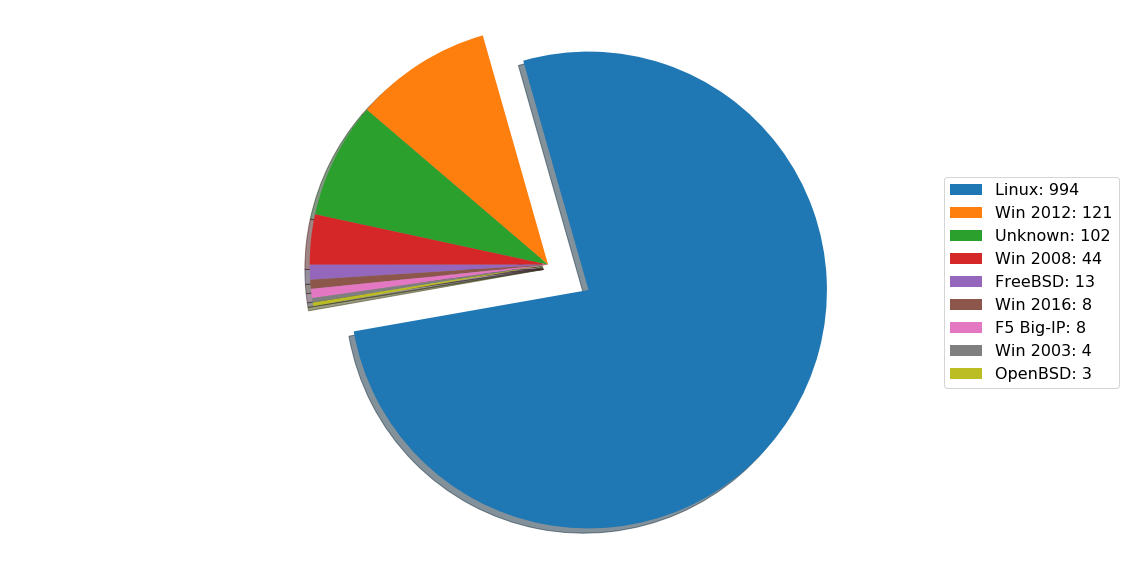

In [50]:

fig1, ax1 = plt.subplots(figsize=(20, 10))
patches = ax1.pie(sizes[:-1], explode=explode, shadow=True, startangle=190,labeldistance=1.05 )

ax1.axis('equal')  
plt.legend(labels,loc='right', prop={'size': 16});


plt.show()






### Top attackers

In [51]:
attackers=returnDict('attacker')

In [52]:
attackers=attackers[0:20]

In [53]:
tmp=pd.DataFrame(attackers)

In [54]:
tmp.columns=['Attacker','Defacements']

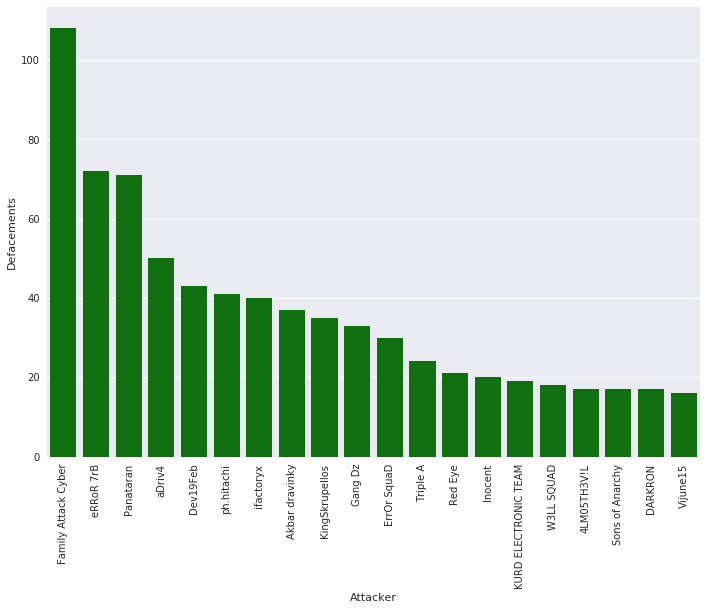

In [59]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.barplot(x="Attacker", y="Defacements", data=tmp,color='green')
ax.set_xticklabels(labels=tmp.Attacker.values,rotation=90);

# Location of systems

In [56]:
df.head()

,attacker,date,mirror,os,site
0,./Xi4u7,2019/04/22,/mirror/id/32351245,Linux,sanluis.gob.mx/k.php
1,PekapuranBerjaya,2019/04/22,/mirror/id/32351133,F5 Big-IP,absensi.kemendag.go.id/bitch.html
2,Akbar dravinky,2019/04/22,/mirror/id/32351102,Linux,pkk.mubakab.go.id
3,PRdV,2019/04/22,/mirror/id/32346511,Linux,www.pped.ie.ufrj.br/media/
4,PRdV,2019/04/22,/mirror/id/32346510,Linux,www.app.ie.ufrj.br/media/


In [57]:
srv_list1=df['site']
srv_list2=[]
for i in srv_list1:
    #print(i)
    j=re.sub(r'^https?\:\/\/', '', i, flags=re.I)
    j=j.split("/")[0]
    #print(j)
    srv_list2.append(j)

In [58]:
ip_list=[]
for i in srv_list2:
    try:
        ip=socket.gethostbyname(i)
        ip_list.append(ip)
        #print(str(i)+": "+str(ip))
    except:
        ip_list.append('0.0.0.0')

In [60]:
GEOIP1 = pygeoip.GeoIP("/home/bruck/geoip/GeoIP.dat", pygeoip.MEMORY_CACHE)
GEOIP2 = pygeoip.GeoIP("/home/bruck/geoip/GeoLiteCity.dat", pygeoip.MEMORY_CACHE)
GEOIP3 = pygeoip.GeoIP("/home/bruck/geoip/GeoIPASNum.dat", pygeoip.MEMORY_CACHE)

In [64]:
df.reset_index(inplace=True)

In [66]:
df=df[df.columns[1:]]

In [67]:
df

,attacker,date,mirror,os,site,ip
0,./Xi4u7,2019/04/22,/mirror/id/32351245,Linux,sanluis.gob.mx/k.php,143.255.56.162
1,PekapuranBerjaya,2019/04/22,/mirror/id/32351133,F5 Big-IP,absensi.kemendag.go.id/bitch.html,180.250.76.101
2,Akbar dravinky,2019/04/22,/mirror/id/32351102,Linux,pkk.mubakab.go.id,103.105.195.230
3,PRdV,2019/04/22,/mirror/id/32346511,Linux,www.pped.ie.ufrj.br/media/,146.164.3.45
4,PRdV,2019/04/22,/mirror/id/32346510,Linux,www.app.ie.ufrj.br/media/,146.164.3.45
5,PRdV,2019/04/22,/mirror/id/32346502,Linux,www.gic.ie.ufrj.br/media/,146.164.3.45
6,Mamad Warning,2019/04/22,/mirror/id/32349593,Win 2016,apps.secb.gov.sa/ir.html,84.235.37.156
7,Bax 026 Of Iran,2019/04/22,/mirror/id/32349613,Unknown,online.scth.gov.sa/ir.html,84.235.37.139
8,Mamad Warning,2019/04/22,/mirror/id/32349595,Unknown,pressfile.scth.gov.sa/ir.html,84.235.37.139
9,Mamad Warning,2019/04/22,/mirror/id/32349594,Win 2016,nbhc.gov.sa/ir.html,84.235.37.156


In [68]:
#df_tmp

In [69]:
df['ip']=ip_list

df_tmp=pd.DataFrame()
for ip in ip_list:
    df_tmp=df_tmp.append(pd.DataFrame(GEOIP2.record_by_addr(ip),index=[0]))
df_tmp.reset_index(inplace=True)
result=pd.concat([df,df_tmp],axis=1)

/home/bruck/.conda/envs/Bruckenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [70]:
result.head()

,attacker,date,mirror,os,site,ip,index,area_code,city,continent,country_code,country_code3,country_name,dma_code,latitude,longitude,metro_code,postal_code,region_code,time_zone
0,./Xi4u7,2019/04/22,/mirror/id/32351245,Linux,sanluis.gob.mx/k.php,143.255.56.162,0,0.0,Guadalajara,NA,MX,MEX,Mexico,0.0,20.5789,-103.2778,None,44510,14,America/Mazatlan
1,PekapuranBerjaya,2019/04/22,/mirror/id/32351133,F5 Big-IP,absensi.kemendag.go.id/bitch.html,180.250.76.101,0,0.0,Tangerang,AS,ID,IDN,Indonesia,0.0,-6.1781,106.6300,None,None,30,Asia/Jakarta
2,Akbar dravinky,2019/04/22,/mirror/id/32351102,Linux,pkk.mubakab.go.id,103.105.195.230,0,0.0,None,AS,ID,IDN,Indonesia,0.0,3.5833,98.6667,None,None,26,Asia/Pontianak
3,PRdV,2019/04/22,/mirror/id/32346511,Linux,www.pped.ie.ufrj.br/media/,146.164.3.45,0,0.0,Rio De Janeiro,SA,BR,BRA,Brazil,0.0,-22.8751,-43.2775,None,None,21,America/Sao_Paulo
4,PRdV,2019/04/22,/mirror/id/32346510,Linux,www.app.ie.ufrj.br/media/,146.164.3.45,0,0.0,Rio De Janeiro,SA,BR,BRA,Brazil,0.0,-22.8751,-43.2775,None,None,21,America/Sao_Paulo


In [71]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

In [72]:
latlongframe=result.copy()
latlongframe=latlongframe[['latitude','longitude','country_name','continent']]

In [73]:
len(latlongframe)

1298

In [74]:
latlongframe=latlongframe.dropna()
len(latlongframe)

1004

In [75]:
latlongframe=latlongframe.groupby(['latitude', 'longitude', 'country_name','continent']).size().reset_index(name='count')


In [76]:
latlongframe.head()

,latitude,longitude,country_name,continent,count
0,-41.0000,174.0000,New Zealand,OC,1
1,-34.6033,-58.3817,Argentina,SA,2
2,-34.6033,-58.3816,Argentina,SA,2
3,-34.5883,-58.6390,Argentina,SA,3
4,-32.9468,-60.6393,Argentina,SA,4


In [77]:
latlongframe['Coordinates'] = list(zip(latlongframe.longitude, latlongframe.latitude))

In [78]:
latlongframe.head()

,latitude,longitude,country_name,continent,count,Coordinates
0,-41.0000,174.0000,New Zealand,OC,1,"(174.0, -41.0)"
1,-34.6033,-58.3817,Argentina,SA,2,"(-58.381699999999995, -34.60329999999999)"
2,-34.6033,-58.3816,Argentina,SA,2,"(-58.381600000000006, -34.60329999999999)"
3,-34.5883,-58.6390,Argentina,SA,3,"(-58.638999999999996, -34.588300000000004)"
4,-32.9468,-60.6393,Argentina,SA,4,"(-60.639300000000006, -32.946799999999996)"


In [79]:
#cities

In [80]:
latlongframe['Coordinates'] = latlongframe['Coordinates'].apply(Point)

In [81]:
latlongframe.head()

,latitude,longitude,country_name,continent,count,Coordinates
0,-41.0000,174.0000,New Zealand,OC,1,POINT (174 -41)
1,-34.6033,-58.3817,Argentina,SA,2,POINT (-58.3817 -34.60329999999999)
2,-34.6033,-58.3816,Argentina,SA,2,POINT (-58.38160000000001 -34.60329999999999)
3,-34.5883,-58.6390,Argentina,SA,3,POINT (-58.639 -34.5883)
4,-32.9468,-60.6393,Argentina,SA,4,POINT (-60.63930000000001 -32.9468)


In [82]:
gdf = gpd.GeoDataFrame(latlongframe, geometry='Coordinates')

In [83]:
gdf.head()

,latitude,longitude,country_name,continent,count,Coordinates
0,-41.0000,174.0000,New Zealand,OC,1,POINT (174 -41)
1,-34.6033,-58.3817,Argentina,SA,2,POINT (-58.3817 -34.60329999999999)
2,-34.6033,-58.3816,Argentina,SA,2,POINT (-58.38160000000001 -34.60329999999999)
3,-34.5883,-58.6390,Argentina,SA,3,POINT (-58.639 -34.5883)
4,-32.9468,-60.6393,Argentina,SA,4,POINT (-60.63930000000001 -32.9468)


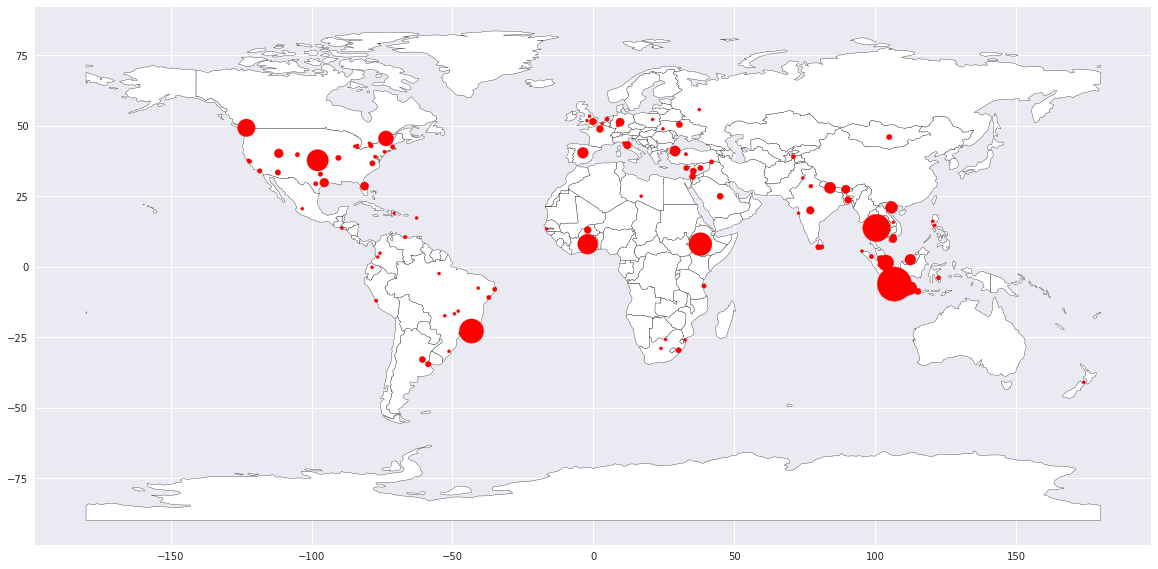

In [84]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black',figsize=(20,10))
gdf.plot(ax=ax, color='red',markersize=gdf['count']*10)
plt.show()

In [111]:
set(result['continent'])

{'AF', 'AS', 'EU', 'NA', 'OC', 'SA', nan}

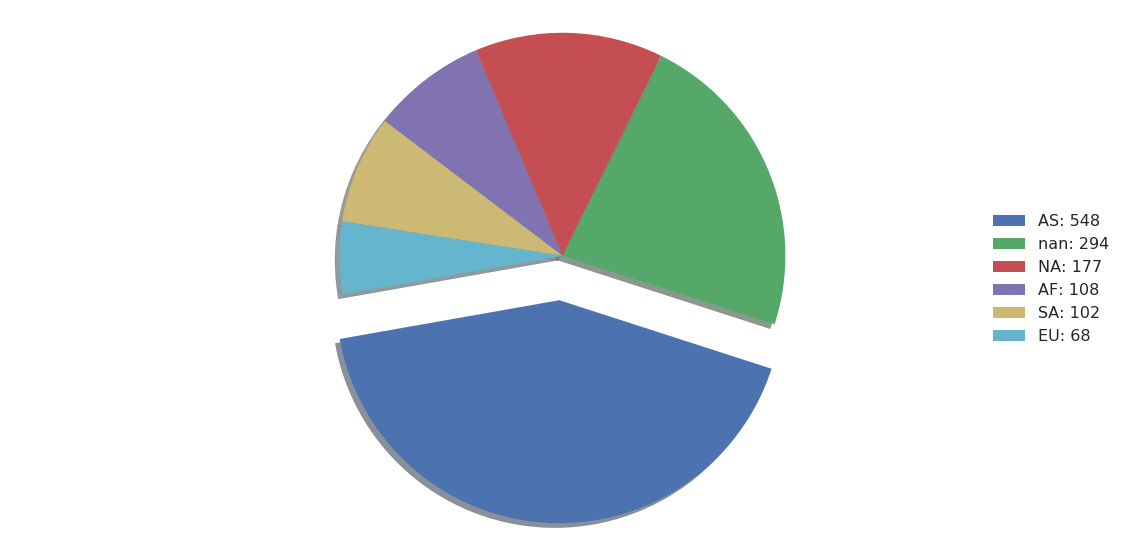

In [113]:
mydict = returnDict(result['continent'])
labels = [str(x[0])+": "+str(x[1]) for x in mydict]
sizes = [x[1] for x in mydict]
explode= (0.2,0,0,0,0,0)
fig1, ax1 = plt.subplots(figsize=(20, 10))
patches = ax1.pie(sizes[:-1], explode=explode, shadow=True, startangle=190,labeldistance=1.05 )

ax1.axis('equal')  
plt.legend(labels,loc='right', prop={'size': 16});


plt.show()

In [120]:
result[result['continent'].isna()].head()

,attacker,date,mirror,os,site,ip,index,area_code,city,continent,country_code,country_code3,country_name,dma_code,latitude,longitude,metro_code,postal_code,region_code,time_zone
10,Family Attack Cyber,2019/04/22,/mirror/id/32342798,Linux,kec-trenggalek.trenggalekkab.g...,0.0.0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Family Attack Cyber,2019/04/22,/mirror/id/32342797,Linux,kec-panggul.trenggalekkab.go.i...,0.0.0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Family Attack Cyber,2019/04/22,/mirror/id/32342792,Linux,kec-gandusari.trenggalekkab.go...,0.0.0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,aDriv4,2019/04/20,/mirror/id/32347989,Linux,bantham.go.th/vz.txt,103.129.15.58,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,DARKRON,2019/04/18,/mirror/id/32342787,Linux,estatistica.prodater.teresina....,0.0.0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Most hit upon Domains

In [192]:
domain=df['site'].apply(lambda x: str(x.split('/')[0]))

In [193]:
at_site=dict(Counter(domain))


In [183]:
sorted(at_site.items(), key=operator.itemgetter(1),reverse=True)[0:10]

[('www.lagesprevi.sc.gov.br', 2),
 ('sanluis.gob.mx', 1),
 ('absensi.kemendag.go.id', 1),
 ('pkk.mubakab.go.id', 1),
 ('www.pped.ie.ufrj.br', 1),
 ('www.app.ie.ufrj.br', 1),
 ('www.gic.ie.ufrj.br', 1),
 ('apps.secb.gov.sa', 1),
 ('online.scth.gov.sa', 1),
 ('pressfile.scth.gov.sa', 1)]

In [187]:
domain=df['site'].apply(lambda x: re.sub(r'(.*)\.([a-z]*)\.([a-z]*)$',r'\2.\3',str(x.split('/')[0]).replace('www.','')) )

In [188]:
at_site=dict(Counter(domain))
del at_site['.']

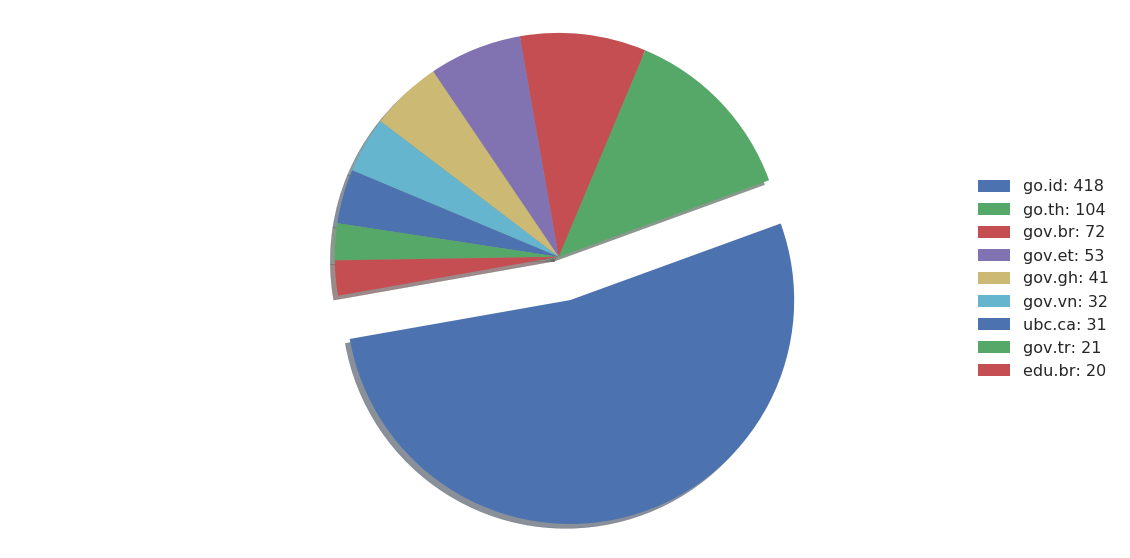

In [191]:



mydict = sorted(at_site.items(), key=operator.itemgetter(1),reverse=True)[0:10]
labels = [str(x[0])+": "+str(x[1]) for x in mydict]
sizes = [x[1] for x in mydict]
explode= (0.2,0,0,0,0,0,0,0,0)
fig1, ax1 = plt.subplots(figsize=(20, 10))
patches = ax1.pie(sizes[:-1], explode=explode, shadow=True, startangle=190,labeldistance=1.05 )

ax1.axis('equal')  
plt.legend(labels,loc='right', prop={'size': 16});


plt.show()

#### How many of these sites are from some government:

In [102]:

len(result[result['site'].str.contains('.go')])/len(result)


0.802773497688752

### South America

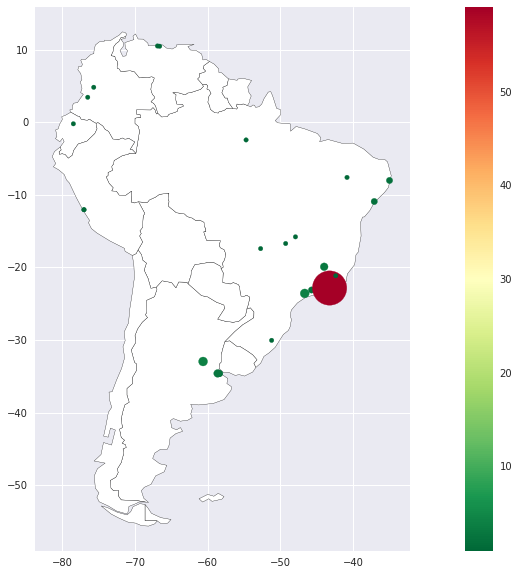

In [85]:
ax = world[world.continent == 'South America'].plot(color='white', edgecolor='black',figsize=(20,10))
tmp=gdf[gdf['continent']=='SA']
tmp.plot(ax=ax,cmap='RdYlGn_r',  column=tmp['count'] , markersize=tmp['count']*20,legend=True)
plt.show()

In [87]:
sadf=result[result['continent']=='SA']

In [96]:
len(sadf[sadf['site'].str.contains('.gov.br')])/len(sadf)

0.5

In [99]:
brdf=result[result['country_code']=='BR']
len(brdf[brdf['site'].str.contains('.gov.br')])/len(brdf)


0.6071428571428571